# FEM Modelling for Single-Phase STEDIN Transformer

### Voltage-fed Analysis - Non-Linear BH Curve

The nonlinear magnetic characteristic with hysteresis neglected can be approximated as given in [1].
\begin{equation}
    \frac{1}{\mu} = k_1 e^{k_2B^2} + k_3
\end{equation}
where, $k_1$, $k_2$ and $k_3$ are constants equal to 3.8, 2.17, and 396.2, respectively.

[1] J. Brauer, “Simple equations for the magnetization and reluctivity curves of steel,” IEEE Transactions on Magnetics, vol. 11, no. 1, pp. 81–81, 1975.

## Import Packages

In [1]:
print(" ▸ Loading Packages .... \r")
start = time_ns()
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_Transient_VoltageFed_Tri_1e.jl");
using .FEM_Transient_VoltageFed_Tri_1e
include("../../../../lib/Post_Process_Time.jl");
using .Post_Process_Time
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Packages loaded ("*string(elapsed)*" seconds)                               ")

 ✓ Packages loaded (32.35 seconds)                               


## BH Curve

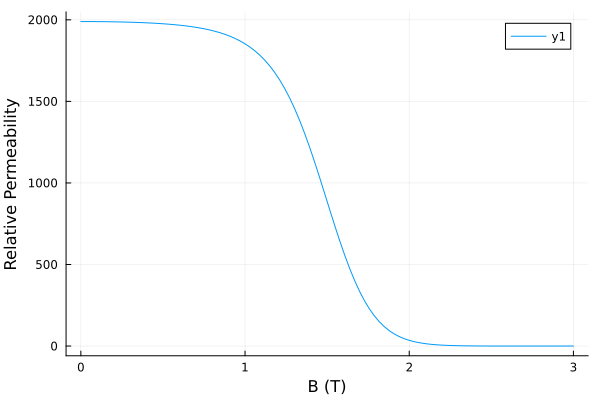

In [2]:
# Plot of mu vs B
mu0 = 4e-7 * pi;
function mu_func(B)
    k1 = 3.8;
    k2 = 2.17;
    k3 = 396.2;
    mu0 = 4e-7 * pi;
    v = k1 * exp.(k2*B.^2) + k3;
    return (1 ./ v)
end

B = collect(range(0, 3.0, 100))
plot(B,mu_func.(B)/mu0)
xlabel!("B (T)")
ylabel!("Relative Permeability")

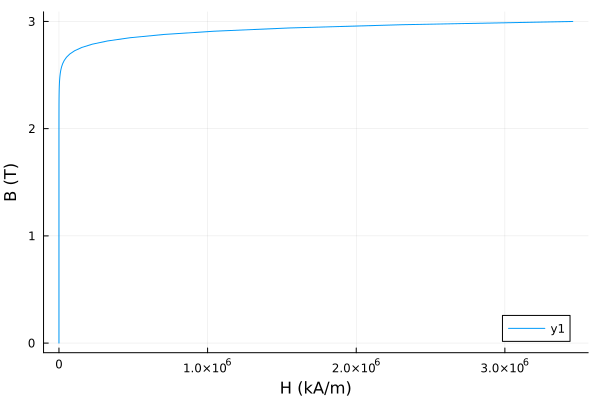

In [3]:
plot(B./mu_func.(B)/1000,B)
xlabel!("H (kA/m)")
ylabel!("B (T)")

## Julia code

In [4]:
gmsh.initialize()

## Read mesh from file
print(" ▸ Reading mesh file .... \r")
start = time_ns()
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh file loaded ("*string(elapsed)*" seconds)                               ")

print(" ▸ Generating required mesh data .... \r")
start = time_ns()
mesh_data = get_mesh_data_tri_1e(gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh data generated ("*string(elapsed)*" seconds)                               ")

print(" ▸ Setting initial parameters .... \r")
start = time_ns()
Ip = 17.54;   # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Vp = 15202.40;   # Primary peak phase voltage
Vs = 342.93;     # Secondary peak phase voltage
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Specify time start, end and step
init_time = 0
n_cycles = 5
final_time = n_cycles*(2*pi/omega)
dt = (final_time-init_time) / (60*n_cycles)
time_steps = Vector(init_time:dt:final_time)

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==5))  -Tp*(1*(group_id==6))   Ts*(1*(group_id==11))  -Ts*(1*(group_id==12))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp; Vp; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
Rp = 400.655
Rs = 1.2999e-3
ext_resistance = [Rp; Rp; Rs; Rs];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = 1e-3.*[1; 1; 1; 1];

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

# Calculate the vector potential
u = fem_nonlinear(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, time_steps);

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
 ✓ Mesh file loaded (0.06 seconds)                               
 ✓ Mesh data generated (3.59 seconds)                               
 ✓ Initial parameters set (0.38 seconds)                               
 ✓ Matrices constructed (0.89 seconds)                               
 ✓ Solution computed (1259.09 seconds)                               
 ✓ Post processing variables computed (23.52 seconds)                               


## Plots

In [5]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
V1_wave = zeros(length(time_steps),1)
for k = 1:length(time_steps)
    V1_wave[k] = imag(coil_voltage[1].*exp(1im*omega*time_steps[k]))
end
I1_wave = [u_curr[end-2] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];

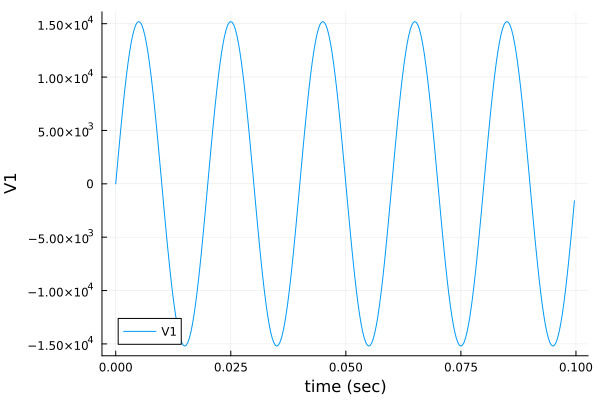

In [6]:
plot(time_steps, V1_wave, label = "V1")
xlabel!("time (sec)")
ylabel!("V1")

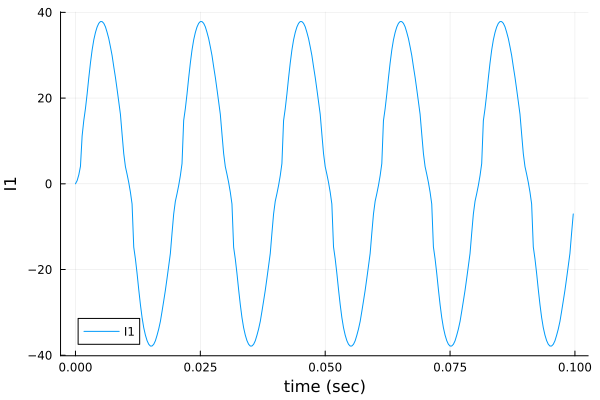

In [7]:
plot(time_steps, I1_wave, label = "I1")
xlabel!("time (sec)")
ylabel!("I1")

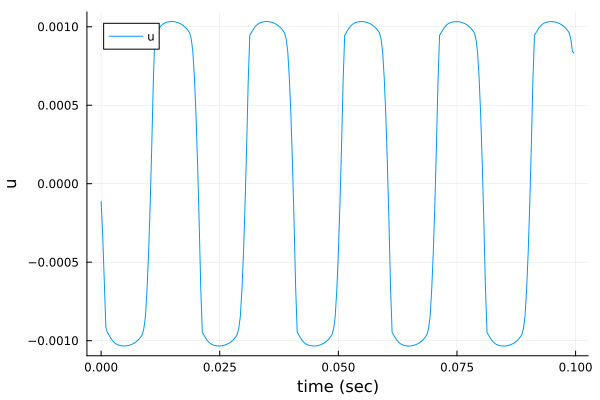

In [8]:
plot(time_steps, u_wave, label = "u")
xlabel!("time (sec)")
ylabel!("u")

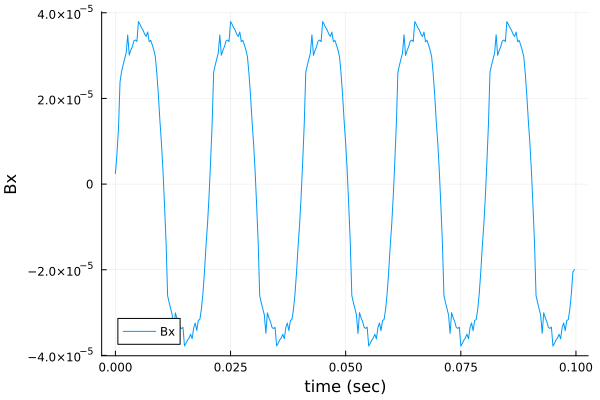

In [9]:
plot(time_steps, Bx_wave, label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

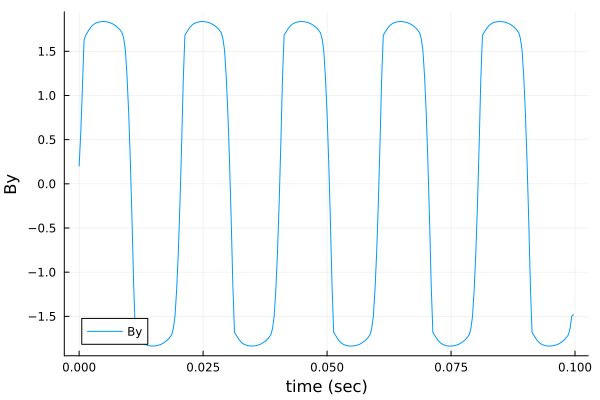

In [10]:
plot(time_steps, By_wave, label = "By")
xlabel!("time (sec)")
ylabel!("By")

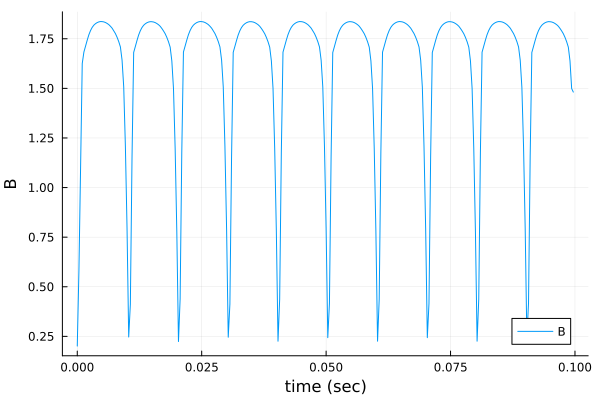

In [11]:
plot(time_steps, B_wave, label = "B")
xlabel!("time (sec)")
ylabel!("B")

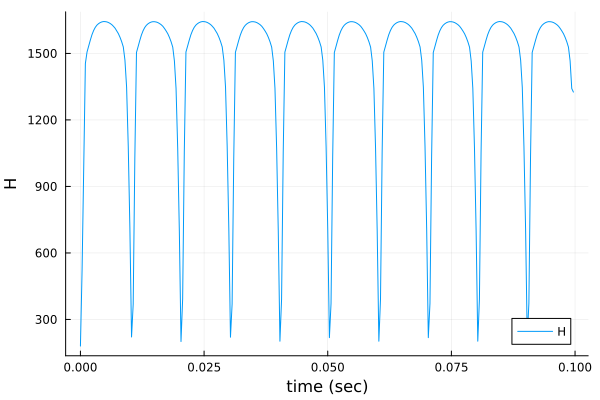

In [12]:
plot(time_steps, H_wave, label = "H")
xlabel!("time (sec)")
ylabel!("H")

In [13]:
print(" ▸ Saving CSV files .... \r")
start = time_ns()
Bx_mat = DataFrame(hcat(Bx...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Bx_voltagefed_nonlinear.csv", Bx_mat)
By_mat = DataFrame(hcat(By...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_By_voltagefed_nonlinear.csv", By_mat)
B_mat = DataFrame(hcat(B...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_B_voltagefed_nonlinear.csv", B_mat)
Hx_mat = DataFrame(hcat(Hx...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Hx_voltagefed_nonlinear.csv", Hx_mat)
Hy_mat = DataFrame(hcat(Hy...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Hy_voltagefed_nonlinear.csv", Hy_mat)
H_mat = DataFrame(hcat(H...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_H_voltagefed_nonlinear.csv", H_mat)
mag_energy_mat = DataFrame(hcat(mag_energy...), :auto)
CSV.write("../csv/single_phase_stedin_transformer_mag_energy_voltagefed_nonlinear.csv", mag_energy_mat)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ CSV files saved ("*string(elapsed)*" seconds)                               ")

 ✓ CSV files saved (15.23 seconds)                               


In [14]:
display(maximum(real(B_wave)))

1.8368250904360466